<a href="https://colab.research.google.com/github/IT17138550/TDM_ML_Assignment-2/blob/main/assignment2code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [16]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools


In [17]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [18]:
content_path = tf.keras.utils.get_file('abandoned-building.jpg', 'https://burst.shopifycdn.com/photos/abandoned-building.jpg?width=1200&format=pjpg&exif=0&iptc=0')
style_path = tf.keras.utils.get_file('hongkong-painted.jpg','http://www.chioka.in/wp-content/uploads/2016/05/hongkong-painted.jpg')

1130496/1122346 [==============================] - 0s 0us/step


In [19]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [20]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

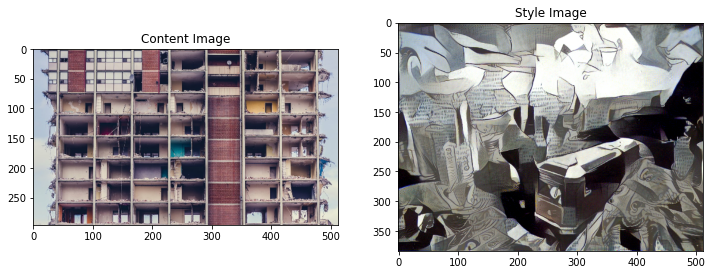

In [21]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

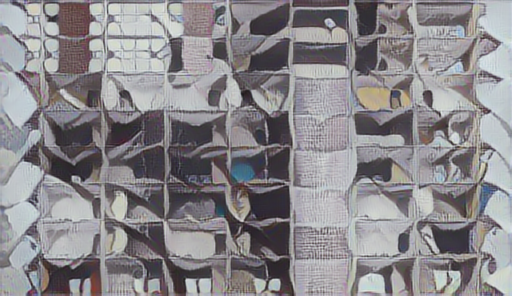

In [22]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [23]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 4s 0us/step


TensorShape([1, 1000])

In [24]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('bookcase', 0.374077),
 ('crate', 0.15091969),
 ('library', 0.11847154),
 ('prison', 0.07045483),
 ('cassette', 0.06636759)]

In [25]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [26]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [27]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [28]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 384, 512, 64)
  min:  0.0
  max:  852.88654
  mean:  25.555803

block2_conv1
  shape:  (1, 192, 256, 128)
  min:  0.0
  max:  4350.415
  mean:  165.78194

block3_conv1
  shape:  (1, 96, 128, 256)
  min:  0.0
  max:  7875.523
  mean:  173.52753

block4_conv1
  shape:  (1, 48, 64, 512)
  min:  0.0
  max:  16601.75
  mean:  643.01544

block5_conv1
  shape:  (1, 24, 32, 512)
  min:  0.0
  max:  2246.4924
  mean:  52.334873



In [29]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [30]:
 class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [31]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  1.3816537e-05
    max:  21384.896
    mean:  816.64954

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  255712.67
    mean:  29855.047

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  1253903.8
    mean:  34256.574

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  11946800.0
    mean:  514344.56

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  691825.25
    mean:  3721.7002

Contents:
   block5_conv2
    shape:  (1, 18, 32, 512)
    min:  0.0
    max:  1261.6349
    mean:  22.569021


In [32]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [33]:
image = tf.Variable(content_image)

In [34]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [35]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [36]:
style_weight=1e-2
content_weight=1e4

In [37]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [38]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

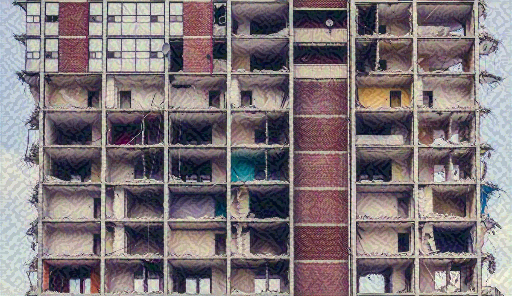

In [39]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

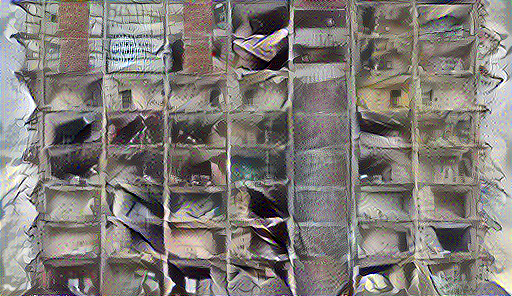

Train step: 1000
Total time: 56.1


In [40]:
import time
start = time.time()

epochs = 11
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [41]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import files

In [42]:
def read_file(filename):
  img = cv2.imread(filename)
  cv2_imshow(img)
  return img

Saving download (3).png to download (3) (1).png


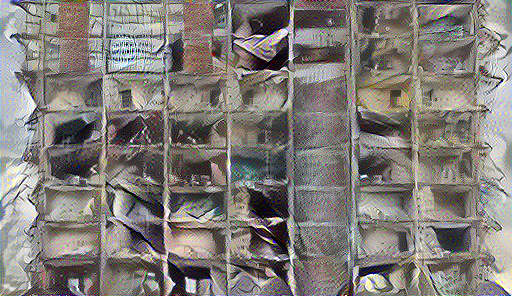

In [43]:
uploaded = files.upload()

filename = next(iter(uploaded))
image = read_file(filename)

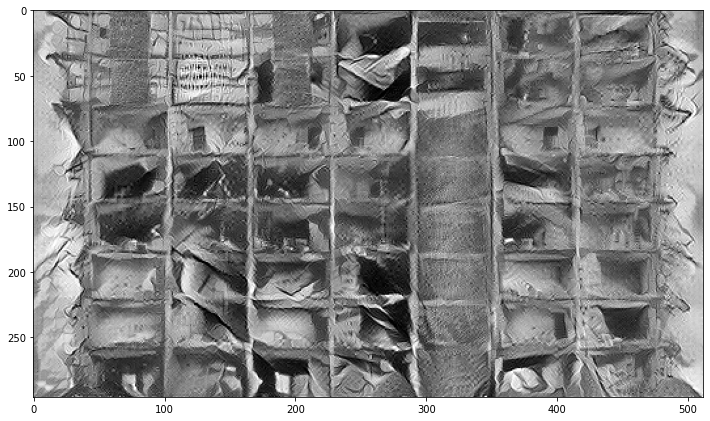

In [44]:

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray, cmap='gray')

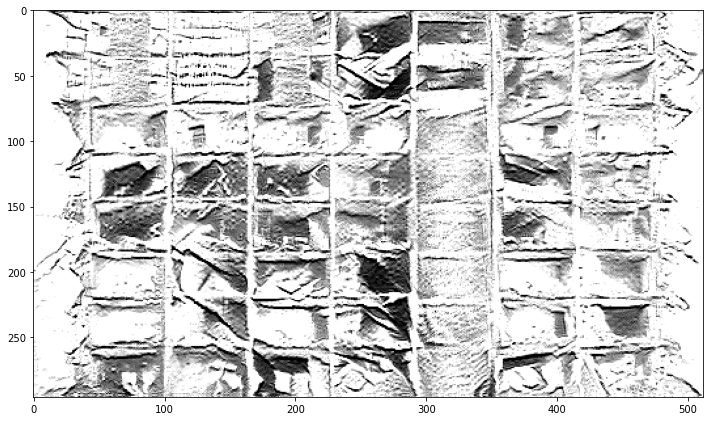

In [45]:

sobel_y = np.array([[ -1, 0, -1], 
                   [ 0, 0, 0], 
                   [ 1, 2, 1]])

sobel_x = np.array([[-1, 0, 1],
                    [-2,0,2],
                    [-1, 0, 1]])

filtered_image = cv2.filter2D(gray, -1, sobel_y)

plt.imshow(filtered_image, cmap='gray')

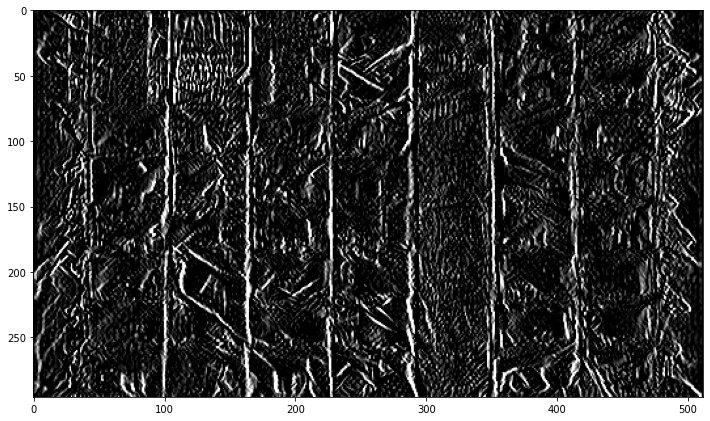

In [46]:
sobel_y = np.array([[ -1, 1, -1], 
                   [ 0, 0, 0], 
                   [ 1, 2, 1]])

sobel_x = np.array([[-1, 0, 1],
                    [-2,0,2],
                    [-1, 0, 1]])

filtered_image = cv2.filter2D(gray, -1, sobel_x)

plt.imshow(filtered_image, cmap='gray')

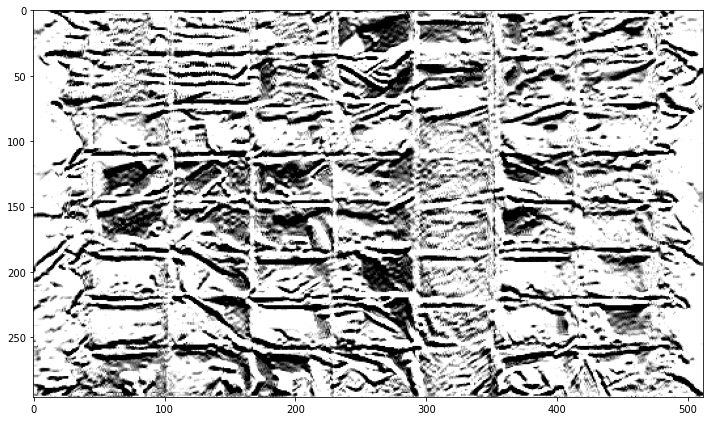

In [47]:
sobel_decimal = np.array([[1,-1,-2,-1,-1],
                          [-1,-1,-2,-1,-1],
                          [0,0,0,0,0],
                          [1,1,2,1,1],
                         [1,1,2,1,1]])
filtered_image = cv2.filter2D(gray, -1, sobel_decimal)

plt.imshow(filtered_image, cmap='gray')